<h1> Compute H0 from strong lenses only </h1>

_<a href="mailto:martin.millon@epfl.ch">Martin Millon</a>,
<a href="mailto:vivien.bonvin@epfl.ch">Vivien Bonvin</a>, 12.2019_

This notebook combines GLEE and Lenstronomy lens models output results. It samples the cosmological parameters in a chosen cosmology and makes a nice $H_0$ inference plot.

The cores functions used here are defined in <a href="lensutils.html">lensutils</a>.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import lensutils as lu


We start by creating "Lens output" objects for each of the strong lens in our analysis. They are labelled GLEE lenses or Lenstronomy lenses, following the kind of output provided by the modeling code we used. More details are given in <a href="lensutils.html">lensutils</a>.

The relevant parameter of the various lens systems can be found here:

 * <a href="http://adsabs.harvard.edu/abs/2010ApJ...711..201S">Suyu et al. 2010</a> for B1608
 * <a href="http://adsabs.harvard.edu/abs/2014ApJ...788L..35S">Suyu et al. 2014</a> for RXJ1131_HST
 * <a href="http://adsabs.harvard.edu/abs/2017MNRAS.465.4895W">Wong et al. 2017</a> for HE0435_HST
 * <a href="http://adsabs.harvard.edu/abs/2018arXiv180901274B">Birrer et al. 2019</a> for J1206
 * <a href="https://ui.adsabs.harvard.edu/abs/2019arXiv190509338R/abstract">Rusu et al. 2019</a> for WFI2033
 * <a href="https://ui.adsabs.harvard.edu/abs/2019arXiv190702533C/abstract">Chen et al. 2019</a> for PG1115, HE0434_AO_HST and RXJ1131_AO_HST
 
The J1206 angular diameter distance posteriors that we use below can be found <a href="data/J1206_final.csv">here</a>. If you wish to access the modeling and analysis scripts for the J1206 analysis, please get in touch with <a href="mailto:sibirrer@gmail.com">Simon Birrer</a>. 



In [4]:
"""Create the lenses objects"""


"""B1608"""
# B1608 using Ddt only, first analysis from Suyu+2010
B1608 = lu.GLEELens(name="B1608", longname="B1608 (Suyu+2010)", zlens=0.6304, zsource=1.394,
                    mu=7.0531390, sigma=0.2282395, lam=4000.0,
                    loglikelihood_type="sklogn_analytical"
                   )

# B1608 using Dd only, analysis from Jee+2019
B1608_Ddonly = lu.GLEELens(name="B1608Dd", longname="B1608 Dd (Jee+2019)", zlens=0.6304, zsource=1.394,
                    mu=7.0531390, sigma=0.2282395, lam=4000.0, mu_Dd = 6.79671, sigma_Dd=0.1836, lam_Dd = 334.2,
                    loglikelihood_type="sklogn_analytical_Ddonly"
                   )
# B1608 using both Ddt and Dd only, analysis from Suyu+2010, Jee+2019, used in Wong+2019
B1608_DdDdt = lu.GLEELens(name="B1608DdDdt", longname="B1608 (Suyu+2010, Jee+2019)", zlens=0.6304, zsource=1.394,
                    mu=7.0531390, sigma=0.2282395, lam=4000.0, mu_Dd = 6.79671, sigma_Dd=0.1836, lam_Dd = 334.2,
                    loglikelihood_type="sklogn_analytical_Dd"
                   )


"""J1206"""
ddt_vs_dd_1206s = pd.read_csv("data/J1206_final.csv")
J1206 = lu.LenstronomyLens(name="J1206", longname="J1206 (Birrer+2019)", zlens=0.745, zsource=1.789, 
                           ddt_vs_dd_samples=ddt_vs_dd_1206s,
                           loglikelihood_type="kde_full", kde_type="scipy_gaussian",
                          )


"""WFI2033"""
#preprocess the 2033 chains...
ddt_2033s_bic = pd.read_csv("data/wfi2033_dt_bic.dat")

# remove the Ddt that are above 8000, as it makes it hard to have a decent kde fit.
cutweights = [w for w, ddt in zip(ddt_2033s_bic["weight"], ddt_2033s_bic["Dt"]) if 0 < ddt < 8000]
cutddts = [ddt for ddt in ddt_2033s_bic["Dt"] if 0 < ddt < 8000] 
ddt_2033s_bic = pd.DataFrame.from_dict(data={"ddt": cutddts, "weight": cutweights})

# create the lens object
WFI2033 = lu.GLEELens(name="WFI2033", longname="WFI2033 (Rusu+2019)", zlens=0.6575, zsource=1.662,
                      loglikelihood_type="kde_hist", kde_kernel="gaussian", ddt_samples=ddt_2033s_bic['ddt'],
                          weights=ddt_2033s_bic['weight'],
                          bandwidth=20, nbins_hist=400
                     )



"""HE0435"""
#Using only HST data, analysis from Wong+2017
HE0435_HST = lu.GLEELens(name="HE0435_HST", longname="HE0435-HST (Wong+2017)", zlens=0.4546, zsource=1.693,
                     mu=7.57930024e+00, sigma=1.03124167e-01, lam=6.53901645e+02,
                     loglikelihood_type="sklogn_analytical"
                    )
                

#Using HST + AO data, analysis from Chen+2019
ddt_0435s_AO_HST = pd.read_csv("data/HE0435_Ddt_AO+HST.dat", delimiter=" ", skiprows=1, names=("ddt",))
ddt_0435s_AO_HST["weight"] = np.ones(len(ddt_0435s_AO_HST["ddt"]))

HE0435_AO_HST = lu.GLEELens(name="HE0435_AO_HST", longname="HE0435 (Wong+2017, Chen+2019)", zlens=0.4546, zsource=1.693,
                    loglikelihood_type="kde_hist", kde_kernel="gaussian", ddt_samples=ddt_0435s_AO_HST['ddt'],
                        weights = ddt_0435s_AO_HST["weight"], 
                      bandwidth=20, nbins_hist=400
                    )


"""RXJ1131"""
#Using only HST data, analysis from Suyu+2014
RXJ1131_HST = lu.GLEELens(name="RXJ1131_HST", longname="RXJ1131-HST (Suyu+2014)", zlens=0.295, zsource=0.654, 
                      mu=6.4682, sigma=0.20560, lam=1388.8, 
                      loglikelihood_type="sklogn_analytical"
                     )


#Using HST + AO data, analysis from Chen+2019
dd_vs_ddt_1131s_AO_HST = pd.read_csv("data/RXJ1131_AO+HST_Dd_Ddt.dat", 
                                  delimiter=" ", skiprows=1, names=("dd", "ddt"))
RXJ1131_AO_HST = lu.GLEELens(name="RXJ1131_AO_HST", longname="RXJ1131 (Suyu+2014, Chen+2019)", 
                              zlens=0.295, zsource=0.654,
                              loglikelihood_type="kde_hist_2d", kde_kernel="gaussian",
                              bandwidth=20, nbins_hist=80,
                              ddt_samples=dd_vs_ddt_1131s_AO_HST["ddt"], dd_samples=dd_vs_ddt_1131s_AO_HST["dd"]
                     )

"""PG1115"""
#Using HST + AO data, analysis from Chen+2019
dd_vs_ddt_1115s= pd.read_csv("data/PG1115_AO+HST_Dd_Ddt.dat", 
                                  delimiter=" ", skiprows=1, names=("dd", "ddt"))
PG1115 = lu.GLEELens(name="PG1115", longname="PG1115 (Chen+2019)", 
                              zlens=0.311, zsource=1.722,
                              loglikelihood_type="kde_hist_2d", kde_kernel="gaussian",
                              bandwidth=20, nbins_hist=80,
                              ddt_samples=dd_vs_ddt_1115s["ddt"], dd_samples=dd_vs_ddt_1115s["dd"]
                     )

    

In [5]:
"""define the lens combinations"""
'''
# H0LiCOW, as in Birrer 2019
lenses_old = [B1608, RXJ1131_HST, HE0435_HST, J1206]

# AO+HST combination, as in Chen 2019
lenses_Chen = [RXJ1131_AO_HST, HE0435_AO_HST, PG1115]

#lenses used in H0LiCOW XIII paper: 
lenses_Wong2019 = [B1608_DdDdt, RXJ1131_AO_HST, HE0435_AO_HST, J1206, WFI2033, PG1115]

'''

# Which lenses set do you want to work on : 
lenses = [B1608_DdDdt, RXJ1131_AO_HST, HE0435_AO_HST, J1206, WFI2033, PG1115]


The cell below contains a couple of useful flag. Leave them all `True` by default - it will save the MCMC chains in a `samples/chosen-cosmology/nwalkers-x-nsamples` folder, for later use.


In [17]:
# compute_individual_samples means that I also sample the cosmological posteriors for each lens individually
# redo_individual_inference means that I recompute the per-lens H0 even if the savefile already exists
compute_individual_samples = True
redo_individual_inference = False
compute_joint_inference = True

#choose your cosmology within : ["FLCDM", "oLCDM" ,"FwCDM", "ULCDM", "w0waCDM"]
cosmologies = ["FLCDM", "oLCDM" ,"FwCDM"]

# True means the MCMC chains computed with emcee are saved on the disk
saveresults = True

# Where do you want to save your chains
samplesdir = "Wong2019"

# Use small numbers just for testing purposes. Should be increased if you want to have robust estimates.
nwalkers = 32 # use 32 for a good sampling 
nsamples = 30000   # use 20000 for a good sampling 

The actual MCMC sampling is done in the cell below. This can take quite some time depending on `nsamples` and `nwalkers` so you might want to adjust them. 

Small chains (6 walkers, 7k samples each) are produced quickly, but are somewhat poorly sampled. You might want to increase the number of walkers to 32 and number of samples to 30000, for example, if you want to produce smoother plots.

Available cosmologies are using the following prior : 
* FLCMD : flat $\Lambda$CDM cosmology, H0 uniform in [0:150], $\Omega_m \in [0.05:0.5]$
* ULCDM : flat $\Lambda$CDM cosmology, H0 uniform in [0:150], $\Omega_m$ fixed to 0.3.
* oLCDM : open-$\Lambda$CDM cosmology with H0 uniform in [0:150], $\Omega_m \in [0.05:0.5]$, $\Omega_k \in [-0.5:0.5]$
* FwCDM : flat wCDM cosmology, with H0 uniform in [0:150], $\Omega_m \in [0.05:0.5]$, $w \in [-2.5:0.5]$
* w0waCDM : flat w0waCDM cosmology, with H0 uniform in [0:150], $\Omega_m \in [0.05:0.5]$, $w_0 \in [-2.5:0.5]$, $w_a\in [-2:2]$

In [11]:
for cosmology in cosmologies :  
    # available cosmo : ["FLCDM", "oLCDM" ,"FwCDM"]
    display("Sampling cosmological parameters in %s..." % cosmology)
    
    savedir = os.path.join(samplesdir, cosmology, "%ix%i" % (nwalkers, nsamples))
    
    if not os.path.exists(savedir):
        display("Creating directory %s" % savedir)
        os.makedirs(savedir)    
    
    
    if compute_joint_inference:
        print("sampling the joint inference...")
        combined_samples = lu.sample_params(lenses, cosmology=cosmology, nwalkers=nwalkers,
                                            nsamples=nsamples, save=saveresults, 
                                            filepath=os.path.join(savedir, "%s_samples.pkl" % ("+".join([l.name for l in lenses]))))

    
    if compute_individual_samples:
        for lens in lenses:
            if redo_individual_inference or (not redo_individual_inference and not os.path.isfile(os.path.join(savedir, "%s_samples.pkl" % lens.name))):
                print("sampling %s..." % lens.name)
                lu.sample_params([lens], cosmology=cosmology, nwalkers=nwalkers,
                                 nsamples=nsamples, save=saveresults, 
                                 filepath=os.path.join(savedir, "%s_samples.pkl" % lens.name))

            else:
                print("skipping %s" % lens.name)

'Sampling cosmological parameters in FLCDM...'

  0%|          | 2/7000 [00:00<06:05, 19.15it/s]

sampling the joint inference...


  0%|          | 17/7000 [00:00<00:42, 163.63it/s]

Autocorrelation time:  [41.98397029 37.71379057]
sampling B1608DdDdt...


  0%|          | 13/7000 [00:00<02:06, 55.39it/s]

Autocorrelation time:  [39.92944158 43.53884919]
sampling RXJ1131_AO_HST...


  0%|          | 28/7000 [00:00<00:55, 126.75it/s]

Autocorrelation time:  [42.55139456 43.14781858]
sampling HE0435_AO_HST...


  0%|          | 8/7000 [00:00<01:32, 75.34it/s]

Autocorrelation time:  [32.91840737 46.08346501]
sampling J1206...


  0%|          | 26/7000 [00:00<00:56, 123.31it/s]

Autocorrelation time:  [45.05450029 40.37353015]
sampling WFI2033...


  0%|          | 13/7000 [00:00<02:03, 56.38it/s]

Autocorrelation time:  [41.92750922 45.56185178]
sampling PG1115...


100%|██████████| 7000/7000 [01:45<00:00, 66.58it/s]

Autocorrelation time:  [37.73184965 49.88106134]


'Sampling cosmological parameters in oLCDM...'

'Creating directory sampling/oLCDM/6x7000'

  0%|          | 2/7000 [00:00<06:12, 18.76it/s]

sampling the joint inference...


  0%|          | 29/7000 [00:00<00:49, 142.26it/s]

Autocorrelation time:  [60.11658998 83.50442672 82.04513575]
sampling B1608DdDdt...


  0%|          | 11/7000 [00:00<02:19, 50.15it/s]

Autocorrelation time:  [57.5470855 65.4306968 65.9336763]
sampling RXJ1131_AO_HST...


  0%|          | 27/7000 [00:00<00:53, 129.98it/s]

Autocorrelation time:  [66.09068098 67.45159763 88.11825945]
sampling HE0435_AO_HST...


  0%|          | 8/7000 [00:00<01:39, 70.39it/s]

Autocorrelation time:  [76.63267313 83.89539622 61.37345635]
sampling J1206...


  0%|          | 27/7000 [00:00<00:53, 129.54it/s]

Autocorrelation time:  [61.92478848 53.36747887 78.56333092]
sampling WFI2033...


  0%|          | 7/7000 [00:00<01:45, 66.39it/s]

Autocorrelation time:  [67.76559634 59.94093822 88.62736944]
sampling PG1115...


100%|██████████| 7000/7000 [01:34<00:00, 73.87it/s]

Autocorrelation time:  [56.65832316 80.28252832 93.83744551]


'Sampling cosmological parameters in FwCDM...'

'Creating directory sampling/FwCDM/6x7000'

  0%|          | 0/7000 [00:00<?, ?it/s]

sampling the joint inference...


  1%|          | 44/7000 [00:00<00:32, 212.87it/s]

Autocorrelation time:  [60.85057078 74.91964979 72.37550798]
sampling B1608DdDdt...


  0%|          | 13/7000 [00:00<01:55, 60.27it/s]

Autocorrelation time:  [93.92451248 93.30986931 97.18476531]
sampling RXJ1131_AO_HST...


  0%|          | 15/7000 [00:00<00:48, 144.33it/s]

Autocorrelation time:  [67.96557024 76.72347298 86.74797609]
sampling HE0435_AO_HST...


  0%|          | 8/7000 [00:00<01:36, 72.45it/s]

Autocorrelation time:  [64.50976293 59.69250408 74.60433381]
sampling J1206...


 66%|██████▌   | 4637/7000 [00:55<00:23, 102.34it/s]/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:43: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)
  0%|          | 32/7000 [00:00<00:42, 162.60it/s]

Autocorrelation time:  [73.57349689 59.23996252 73.08830765]
sampling WFI2033...


  0%|          | 12/7000 [00:00<02:04, 56.24it/s]

Autocorrelation time:  [88.17982634 88.522779   98.46717958]
sampling PG1115...


100%|██████████| 7000/7000 [01:25<00:00, 82.27it/s] 


Autocorrelation time:  [83.30158674 72.75772394 81.14250547]


The cell below will read the saved samples produced by the MCMC sampling above, and make fancy H0 probability plots out of them.

It reads by default the samples generated with the `nwalkers` and `nsamples` parameters defined two cells above.

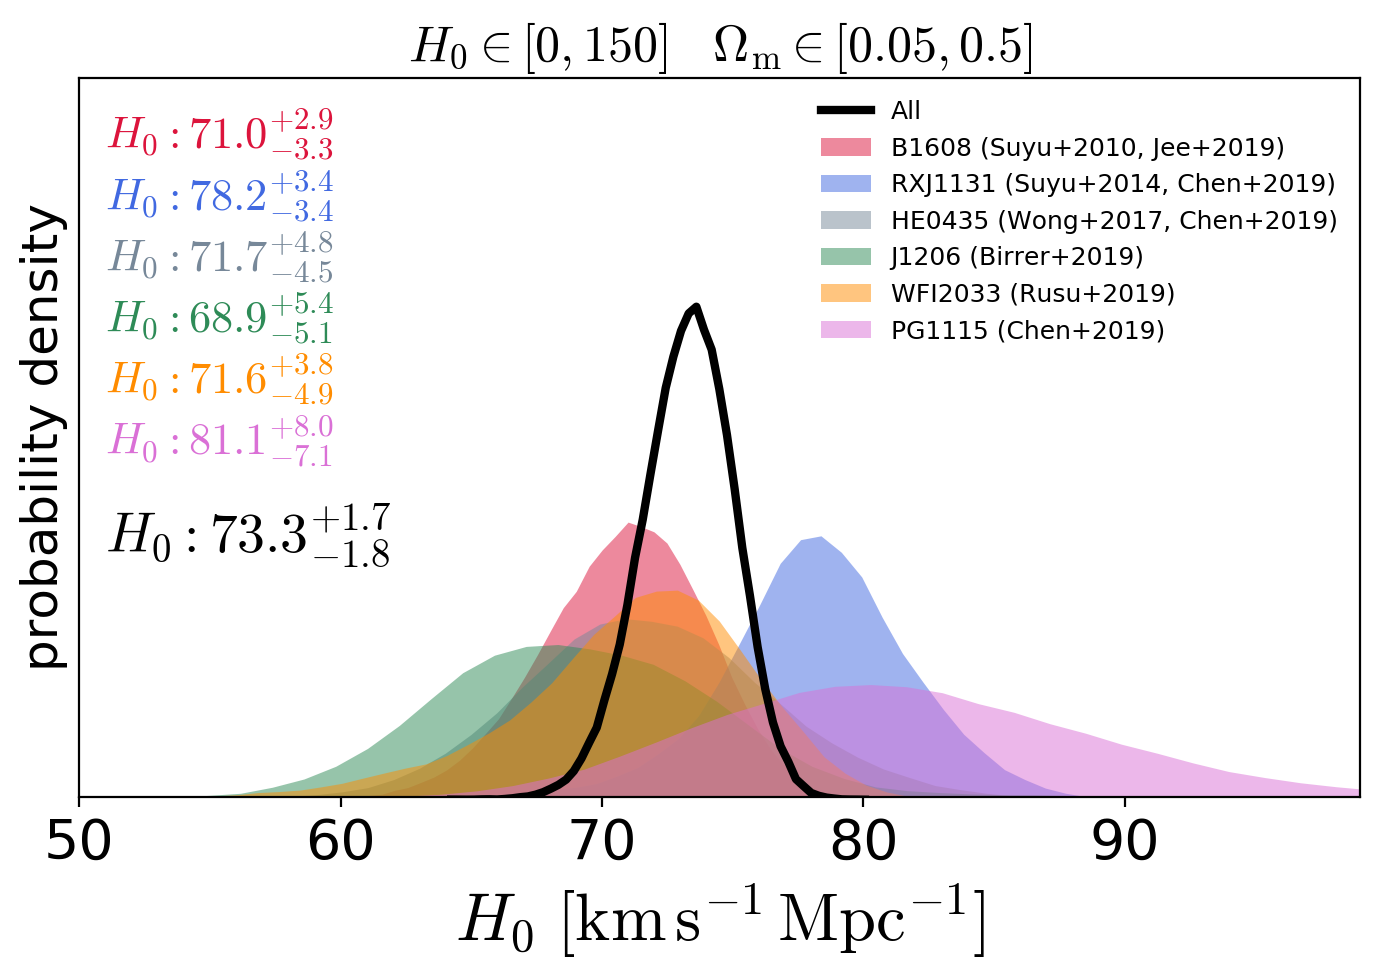

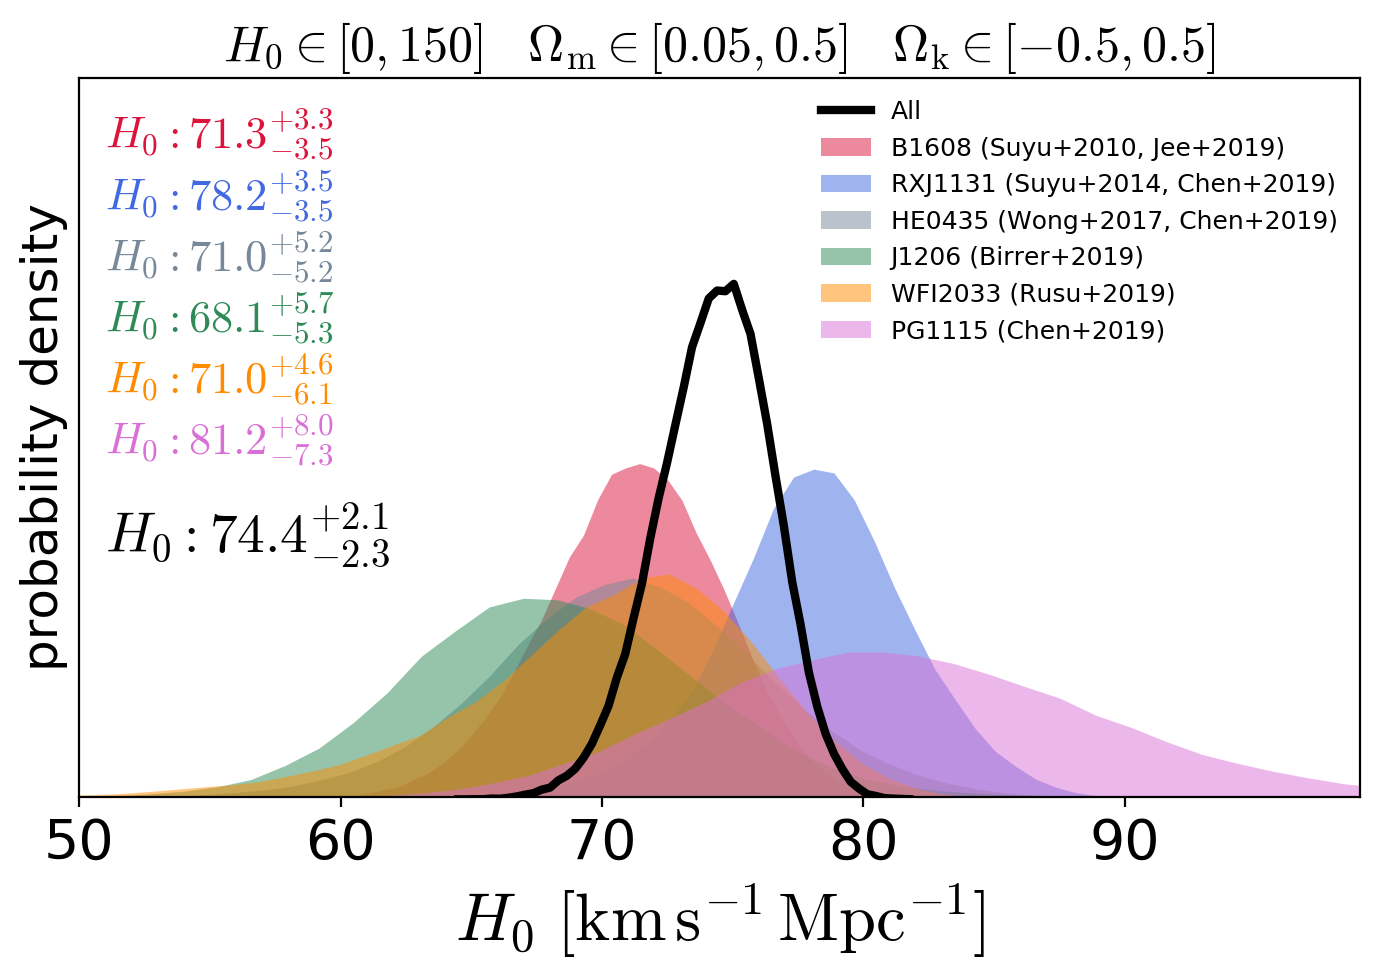

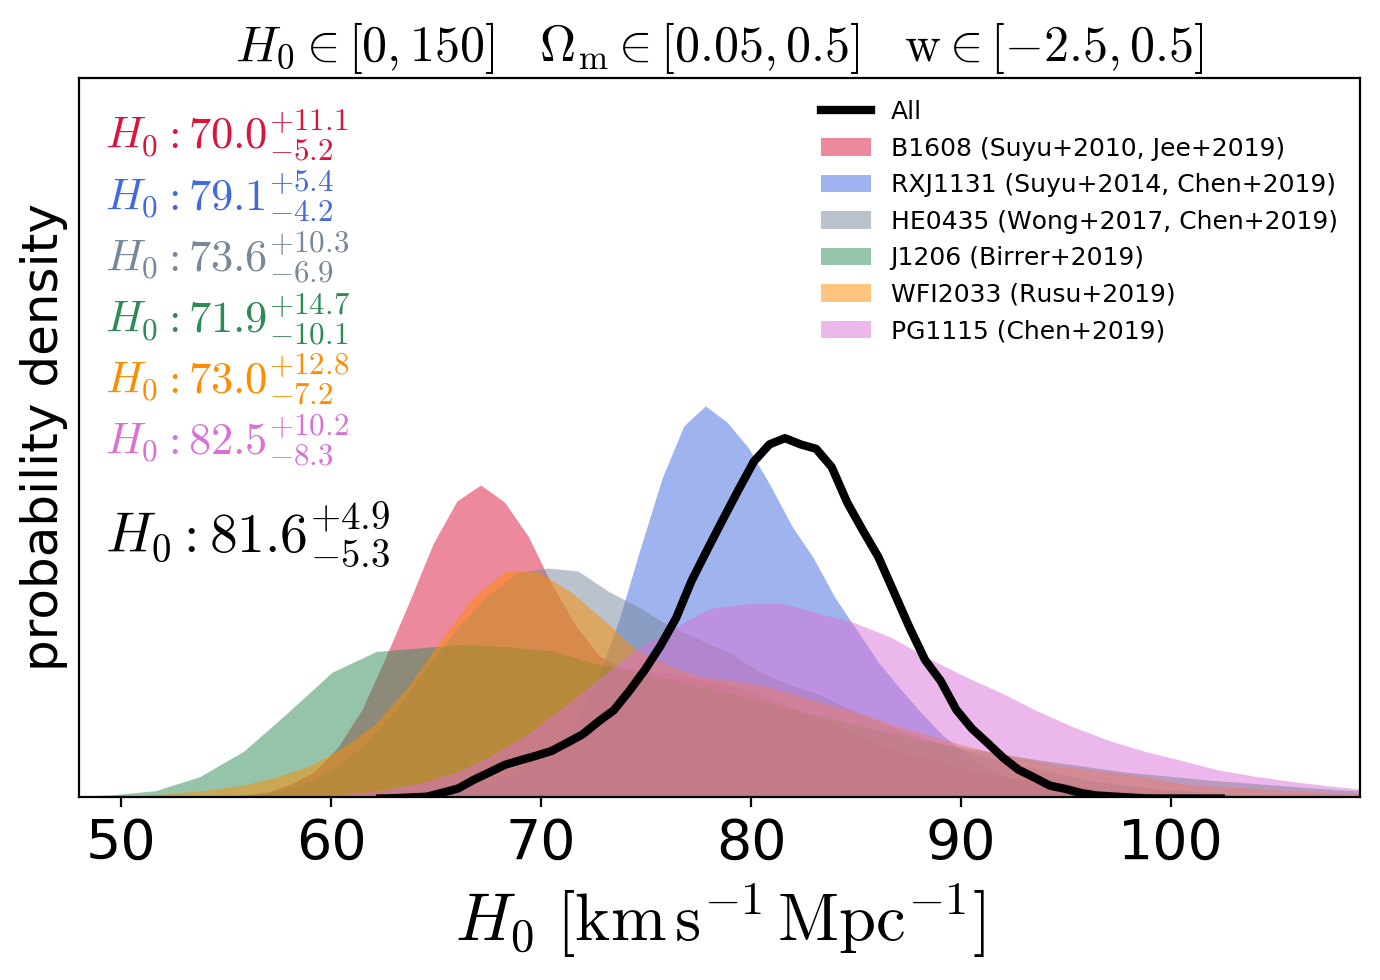

In [18]:
add_logo = False
save_plot = False
plot_combined = True 
for cosmology in cosmologies:

    savedir = os.path.join(samplesdir, cosmology, "%ix%i" % (nwalkers, nsamples))
    samples_list = [lu.readpickle(os.path.join(savedir, "%s_samples.pkl" % lens.name)) for lens in lenses]
    samples_list.append(lu.readpickle(os.path.join(savedir, "%s_samples.pkl" % ("+".join([l.name for l in lenses])))))    
    
    ### plot nice H0s histogram 
    plt.figure(figsize=(7, 5), dpi=200)
    ax = plt.subplot(1, 1, 1)

    H0s_list = [[s[0] for s in samples] for samples in samples_list]
    others_list = [[s[1] for s in samples] for samples in samples_list]
    
    toplot = H0s_list
    
    percentiles = [16, 50, 84]
    #colors = ["crimson", "royalblue", "lightslategrey", "seagreen", "darkorange", "orchid", "mediumturquoise", "black"]
    colors = ["crimson", "royalblue", "lightslategrey", "seagreen", "darkorange", "orchid", "black"]
    nbins = 55
    title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
    fmt = "{{0:{0}}}".format(".1f").format
    fmt2 = "{{0:{0}}}".format(".2f").format


    # loop over the lenses, shaded histograms
    for il, lens in enumerate(lenses):

        h, be = np.histogram(toplot[il], bins=nbins, density=True)
        xs = [(b+be[ind+1])/2. for ind, b in enumerate(be[:-1])]
        plt.plot(xs, h, alpha=0.5, color=colors[il], linewidth=0.0)
        plt.fill_between(xs, h, alpha=0.5, color=colors[il], linewidth=0.0, label=r'%s' % lens.longname)

        # add the values
        pcs = np.percentile(toplot[il], q=percentiles)
        txt = r'$H_{0}: $' + title.format(fmt(pcs[1]), fmt(pcs[1]-pcs[0]), fmt(pcs[2]-pcs[1]))
        plt.annotate(txt, xy=(0.0, 0.0), xytext=(0.02, 0.9-0.085*il), xycoords='axes fraction',
                     fontsize=16, color=colors[il])


    if plot_combined:
    
        # plot the combined result
        h, be = np.histogram(toplot[-1], bins=nbins, density=True)
        xs = [(b+be[ind+1])/2. for ind, b in enumerate(be[:-1])]
        plt.plot(xs, h, alpha=1.0, color=colors[-1], linewidth=3.0, label=r'All')

        # add the values
        pcs = np.percentile(toplot[-1], q=percentiles)
        txt = r'$H_{0}: $' + title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))
        plt.annotate(txt, xy=(0.0, 0.0), xytext=(0.02, 0.85 - 0.085 * len(lenses)), xycoords='axes fraction',
                     fontsize=20, color=colors[-1])
    
    if add_logo : 
        #add H0licow logo 
        from matplotlib._png import read_png
        from matplotlib.offsetbox import OffsetImage, AnnotationBbox

        im = read_png(os.path.join("h0licow_transparent.png"))
        imagebox = OffsetImage(im, zoom=0.09, interpolation="sinc", resample = True)
        ab = AnnotationBbox(imagebox,  xy=(0.88, 0.45), xycoords='axes fraction', xybox = (0, 0),
                boxcoords="offset points",
                pad=0.0, frameon=False
                )
        ax.add_artist(ab)


    # fine tune
    if cosmology == "FLCDM":
        title = r"$H_{\rm{0}} \in \rm{[0, 150]} \ \ \ \Omega _{\rm{m}} \in \rm{[0.05, 0.5]}$"
    elif cosmology == "FwCDM":
        title = r"$H_{\rm{0}} \in \rm{[0, 150]} \ \ \ \Omega _{\rm{m}} \in \rm{[0.05, 0.5]} \ \ \  w \in \rm{[-2.5, 0.5]}$"
    elif cosmology == "oLCDM":
        title = r"$H_{\rm{0}} \in \rm{[0, 150]} \ \ \ \Omega _{\rm{m}} \in \rm{[0.05, 0.5]} \ \ \ \Omega _{\rm{k}} \in \rm{[-0.5, 0.5]}$"
    elif cosmology == "w0waCDM":
        title = r"$H_{\rm{0}} \in \rm{[0, 150]} \ \ \ \Omega _{\rm{m}} \in \rm{[0.05, 0.5]} \ \ \ \Omega _{\rm{k}} \in \rm{[-0.5, 0.5]}$"
    elif cosmology == "ULCDM":
        title = r"$H_{\rm{0}} \in \rm{[0, 150]} \ \ \ \Omega _{\rm{m}} = 0.3$"

    plt.title(title, fontsize=18)
    plt.xlabel(r"$H_{\rm{0}}\rm{\ [km\,s^{-1}\,Mpc^{-1}]}$", fontsize=24)
    plt.ylabel("probability density", fontsize=18)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=20)
    plt.yticks([])

    legend = plt.legend(loc="upper right", prop={'size': 9} )
    legend.get_frame().set_alpha(0.0)
    if cosmology == "FLCDM":
        plt.xlim([50, 99])
        #plt.ylim([max(h)*0.005, max(h)*1.25])
        plt.ylim([0.0013492736086723317, 0.33731840216808295])
    elif cosmology == "oLCDM":
        plt.xlim([50, 99])
        plt.ylim([max(h)*0.005, max(h)*1.4])
    elif cosmology == "FwCDM":
        plt.xlim([48, 109])
        plt.ylim([max(h)*0.005, max(h)*2.0])
    plt.tight_layout()

    if save_plot : 
        plt.savefig(os.path.join(savedir, "H0_%s_%s.png" % (cosmology, "+".join([l.name for l in lenses]))))
        plt.savefig(os.path.join(savedir, "H0_%s_%s.pdf" % (cosmology, "+".join([l.name for l in lenses]))))
    plt.show()
    



